#**POLI170A Project**

Research question: Does increased availability of on-sale alcohol, specifically Type 41 (On-Sale Beer and Wine – Public) and Type 47 (On-Sale General – Eating), lead to higher rates of crime, such as assault or robbery, in communities in San Diego County?

# Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
zipcode_df = pd.read_csv("zipcode.csv", header = None)
zipcode_arr = zipcode_df[0].values

# Alcohol Dataset

Records of alcohol licenses in california, from the CA ABC daily file, with improvements to geographic identifiers, and acompilation of areal densities of on-sale and off-sale licenses in San Diego county.

* ca_abc_licenses. California Alcohol Beverage Control License records
* sd_abc_density. Areal density of on-sale and off-sale licenses in San Diego county

In [3]:
# most update dataset from website
ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)

/tmp/ipykernel_811/735577973.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)


In [4]:
sd_abc_density_df =  pd.read_csv('http://library.metatab.org/abc.ca.gov-licenses-2.1.2/data/sd_abc_density.csv')

Briefly browse dataset

In [5]:
ca_licenses.head(3)

,License Type,File Number,Lic or App,Type Status,Type Orig Iss Date,Expir Date,Fee Codes,Dup Counts,Master Ind,Term in # of Months,...,Prem State,Prem Zip,DBA Name,Mail Addr 1,Mail Addr 2,Mail City,Mail State,Mail Zip,Prem County,Prem Census Tract #
0,77,561256,LIC,ACTIVE,01-DEC-2015,30-NOV-2024,P40,001,N,12,...,CA,91762-3644,FIREWATER BAR,,,,,,SAN BERNARDINO,0010.02
1,48,526584,LIC,ACTIVE,08-JAN-2013,31-DEC-2024,P40,001,N,12,...,CA,94578-2815,CLUB CALIENTE,PO BOX 3541,,SAN LEANDRO,CA,94578-0541,ALAMEDA,4331.03
2,77,518989,LIC,ACTIVE,21-JUN-2012,31-MAY-2024,P40,001,N,12,...,CA,93001-2826,BARRELHOUSE 101,,,,,,VENTURA,0024.00


In [6]:
ca_licenses.columns

Index(['License Type', 'File Number', 'Lic or App', 'Type Status',
       'Type Orig Iss Date', 'Expir Date', 'Fee Codes', 'Dup Counts',
       'Master Ind', 'Term in # of Months', 'Geo Code', 'District',
       'Primary Name', 'Prem Addr 1', ' Prem Addr 2', 'Prem City',
       ' Prem State', 'Prem Zip', 'DBA Name', 'Mail Addr 1', 'Mail Addr 2',
       'Mail City', 'Mail State', 'Mail Zip', 'Prem County',
       'Prem Census Tract #'],
      dtype='object')

## Data Cleaning

1. dealing with license issue date, expire date

In [7]:
# drop rows with NaN values in 'Type Orig Iss Date' and 'Expir Date'
ca_licenses['Type Orig Iss Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses['Expir Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses.dropna(subset=['Type Orig Iss Date', 'Expir Date'], inplace=True)

# convert to datatime
ca_licenses['Type Orig Iss Date'] = pd.to_datetime(ca_licenses['Type Orig Iss Date'], format='%d-%b-%Y')
ca_licenses['Expir Date'] = pd.to_datetime(ca_licenses['Expir Date'], format='%d-%b-%Y')

2. transform all zipcode into 5-digits format

In [8]:
ca_licenses['Prem Zip'] = ca_licenses['Prem Zip'].str.slice(0, 5)

3. filter the dataframe based on the following conditions:
  * Is an active License (Lic) not an Application (App) that is still being processed
  * issue date before 2016-01-01
  * expire date after 2020-07-31
  * license is active
  * license type is 41, 47, or **48**?
  (41; On-Sale Beer and Wine – Public, 47: On-Sale General – Eating, 48: On-Sale General — Public ( Bars and Nightclubs ))
  * license is used within San Diego

In [9]:
df_alcohol = ca_licenses[
    (ca_licenses['Lic or App'] == 'LIC') &
    (ca_licenses['Type Orig Iss Date'] < '2016-01-01') &
    (ca_licenses['Expir Date'] > '2020-07-31') &
    (ca_licenses['Type Status'] == 'ACTIVE') &
    ((ca_licenses['License Type'] == 47) | (ca_licenses['License Type'] == 41)) &
    (ca_licenses['Prem County'] == "SAN DIEGO")
].reset_index(drop = True)

4. select important features <br>
**undecided keep which**

In [10]:
sub_alcohol = df_alcohol[['Type Orig Iss Date', 'Expir Date', 'DBA Name', 'Prem Addr 1', 'Prem City', 'Prem Zip']]
sub_alcohol.head(5)

,Type Orig Iss Date,Expir Date,DBA Name,Prem Addr 1,Prem City,Prem Zip
0,2013-01-16,2024-12-31,LAUBERGE DEL MAR,1540 CAMINO DEL MAR,DEL MAR,92014
1,1993-12-31,2024-11-30,CATAMARAN RESORT HOTEL,3999 MISSION BLVD,SAN DIEGO,92109
2,2012-01-12,2024-12-31,MANCHESTER GRAND HYATT SAN DIEGO,ONE MARKET PLACE,SAN DIEGO,92101
3,2012-01-19,2024-12-31,BARLEY MASH,600 5TH AVE,SAN DIEGO,92101
4,2012-11-30,2024-12-31,BEAUDEVIN,3707 N HARBOR DR,SAN DIEGO,92101


In [11]:
sub_alcohol.shape

(1500, 6)

## EDA

Count the number of licenses based on cities in San Diego

In [12]:
sub_alcohol['Prem City'].unique()

array(['DEL MAR', 'SAN DIEGO', 'LA MESA', 'ESCONDIDO', 'RAMONA', 'POWAY',
       'CARLSBAD', 'LA JOLLA', 'ENCINITAS', 'SANTEE', 'OCEANSIDE',
       'EL CAJON', 'SOLANA BEACH', 'SAN MARCOS', 'VISTA', 'PAUMA VALLEY',
       'IMPERIAL BEACH', 'NATIONAL CITY', 'BONSALL', 'CORONADO',
       'CHULA VISTA', 'LAKESIDE', 'BORREGO SPRINGS', 'JAMUL', 'FALLBROOK',
       'PALA', 'PALOMAR MOUNTAIN', 'BONITA', 'ALPINE', 'SAN YSIDRO',
       'CARDIFF BY THE SEA', 'SPRING VALLEY', 'VALLEY CENTER', 'CAMPO',
       'LEMON GROVE', 'RANCHO SANTA FE', 'DULZURA', 'DESCANSO', 'JULIAN'],
      dtype=object)

In [13]:
nlicense = sub_alcohol.groupby('Prem City')['DBA Name'].count().sort_values(ascending = False)
nlicense

Prem City
SAN DIEGO             769
CHULA VISTA            70
CARLSBAD               62
OCEANSIDE              61
LA JOLLA               59
ESCONDIDO              55
EL CAJON               42
LA MESA                41
SAN MARCOS             39
ENCINITAS              38
CORONADO               31
VISTA                  29
SOLANA BEACH           25
SANTEE                 21
NATIONAL CITY          18
POWAY                  17
DEL MAR                15
RAMONA                 14
FALLBROOK              14
ALPINE                 10
BORREGO SPRINGS         8
LAKESIDE                8
IMPERIAL BEACH          7
BONITA                  6
RANCHO SANTA FE         6
VALLEY CENTER           6
SPRING VALLEY           5
BONSALL                 5
LEMON GROVE             4
PAUMA VALLEY            3
PALA                    2
CARDIFF BY THE SEA      2
JAMUL                   2
PALOMAR MOUNTAIN        1
DESCANSO                1
SAN YSIDRO              1
CAMPO                   1
JULIAN                  1
DU

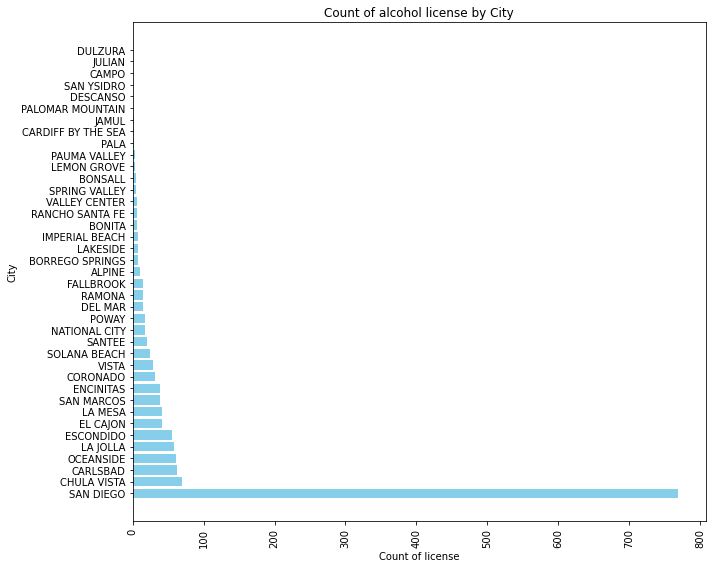

In [14]:
plt.figure(figsize=(10, 8))
plt.barh(nlicense.index, nlicense.values, color='skyblue')
plt.xlabel('Count of license')
plt.ylabel('City')
plt.title('Count of alcohol license by City')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Crime Dataset

This dataset describes crime incidents from 2016 to 2020, with demographic information for the victims. The file has one row per incident. The dataset is derived from data acquired for a PRA request and is processed to standardize geographic identifiers and racial categories.

In [15]:
crime_df =  pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/sdcrime_16_20_uniquecase.csv')
ucrcodes_df = pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/ucrcodes.csv')

Briefly browse dataset

In [16]:
crime_df.head(3)

,activitynumber,activitydate,year,agency,violationsection,violationtype,chargedescription,chargelevel,codeucr,crimecategory,personrole,race,age,sex,zipcode,censusblock,censustract,city,city.1
0,'01600014',2016-01-01 00:00:00,2016,NATIONAL CITY,10851,VC,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,FELONY,7A0,Vehicle Theft,VICTIM,OTHER,NaN,FEMALE,91950.0,'02000','022000',NATIONAL CITY,NATIONAL CITY
1,'16000042',2016-01-01 00:00:00,2016,SAN DIEGO,459,PC,BURGLARY/UNSPECIFIED,FELONY,5A6,Non Res Burglary,NaN,NaN,NaN,NaN,92109.0,'20000','007907',SAN DIEGO,SAN DIEGO
2,'16005661',2016-01-01 00:00:00,2016,SAN DIEGO,488,PC,PETTY THEFT,MISDEMEANOR,6DG,Larceny < $400,VICTIM/WITNESS,HISPANIC,74.0,MALE,92115.0,'20230','002902',SAN DIEGO,SAN DIEGO


In [17]:
crime_df.columns

Index(['activitynumber', 'activitydate', 'year', 'agency', 'violationsection',
       'violationtype', 'chargedescription', 'chargelevel', 'codeucr',
       'crimecategory', 'personrole', 'race', 'age', 'sex', 'zipcode',
       'censusblock', 'censustract', 'city', 'city.1'],
      dtype='object')

## Data Cleaning

1. clean columns: city, zipcode

In [18]:
# keep one of them is enough
(crime_df['city'] == crime_df['city.1']).all()

True

In [19]:
# drop all rows that containing nan in zipcode
crime_df = crime_df.dropna(subset=['zipcode'])

# convert zipcode type into int64
crime_df.loc[:, 'zipcode'] = crime_df['zipcode'].astype(int)

# filter df only include sd cities
crime_df = crime_df[crime_df['zipcode'].isin(zipcode_arr)]

# convert datatype of zipcode
crime_df['zipcode'] = crime_df['zipcode'].astype(int)

In [20]:
crime_df['city'] = crime_df['city'].str.strip()
crime_df['city'] = crime_df['city'].str.replace(r'\bUNINC\b|\bUNIN\b', '', regex=True)
crime_df['city'] = crime_df['city'].replace({'SAM DIEGO': 'SAN DIEGO', 'SAN SIEGO': 'SAN DIEGO',
                        '5310 LA MESA': 'LA MESA', 'LAMESA': 'LA MESA',
                        '92013': 'CARLSBAD', 'SPING VALLEY': 'SPRING VALLEY',
                        'SAN YSABEL': 'SANTA YSABEL'})

crime_df = crime_df[(crime_df['city'] != 'CN') & (crime_df['city'] != 'SD COUNTY')]

2. select columns

**undecided yet**<br>
**select a variable used as confounding variable:**
* violationtype* violent or property
* activitydate: daytime or nighttime
* sex: female or male
* age: young or old

In [21]:
sub_crime = crime_df[['activitydate', 'year', 'violationtype', 'crimecategory', 'race', 'age', 'sex', 'zipcode', 'city']]

In [22]:
sub_crime.head(3)

,activitydate,year,violationtype,crimecategory,race,age,sex,zipcode,city
0,2016-01-01 00:00:00,2016,VC,Vehicle Theft,OTHER,NaN,FEMALE,91950,NATIONAL CITY
1,2016-01-01 00:00:00,2016,PC,Non Res Burglary,NaN,NaN,NaN,92109,SAN DIEGO
2,2016-01-01 00:00:00,2016,PC,Larceny < $400,HISPANIC,74.0,MALE,92115,SAN DIEGO


In [23]:
sub_crime.shape

(298154, 9)

## EDA

In [24]:
sub_crime['city'].unique()

array(['NATIONAL CITY', 'SAN DIEGO', 'EL CAJON', 'OCEANSIDE', 'ESCONDIDO',
       'RANCHO SANTA FE', 'PINE VALLEY', 'VISTA ', 'POWAY', 'RAMONA',
       'LA MESA', 'SAN MARCOS', 'PAUMA VALLEY', 'FALLBROOK', 'ALPINE',
       'DEL MAR', 'LEMON GROVE', 'CARLSBAD', 'LAKESIDE', 'SOUTH BAY',
       'CHULA VISTA', 'ENCINITAS', 'VALLEY CENTER', 'LA MESA ',
       'IMPERIAL BEACH', 'SHERIFF', 'SPRING VALLEY', 'SOLANA BEACH',
       'EL CAJON ', 'BONITA', '4S RANCH', 'VISTA', 'PALA', 'SANTEE',
       'ESCONDIDO ', 'JULIAN', 'SAN MARCOS ', 'BOULEVARD',
       'WARNER SPRINGS', 'JACUMBA', 'SANTA YSABEL', 'DESCANSO',
       'PALOMAR MOUNTAIN', 'CAMPO', 'LINCOLN ACRES', 'OTAY', 'BONSALL',
       'CORONADO', 'JAMUL', 'DULZURA', 'RANCHITA', 'POWAY ',
       'BORREGO SPRINGS', 'LA JOLLA', 'TECATE', 'CARDIFF BY THE SEA',
       'CAMP PENDLETON', 'POTRERO', 'SAN YSIDRO', 'MOUNT LAGUNA',
       'GUATAY', 'ENCINITAS '], dtype=object)

In [25]:
ncrime = sub_crime.groupby('city')['activitydate'].count().sort_values(ascending = False)
ncrime

city
SAN DIEGO       155309
CHULA VISTA      22689
OCEANSIDE        12044
SOUTH BAY        10773
VISTA             8009
                 ...  
SAN YSIDRO           9
POTRERO              8
MOUNT LAGUNA         8
GUATAY               4
ENCINITAS            1
Name: activitydate, Length: 62, dtype: int64

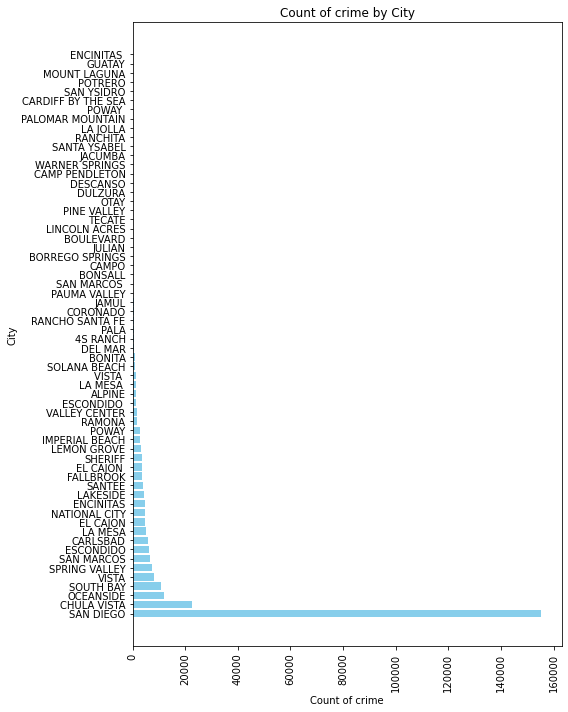

In [26]:
plt.figure(figsize=(8, 10))
plt.barh(ncrime.index, ncrime.values, color='skyblue')
plt.xlabel('Count of crime')
plt.ylabel('City')
plt.title('Count of crime by City')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
# create df with nlicense and ncrime
# convert the Series to DataFrames
df_license = nlicense.to_frame(name='license_count')
df_crime = ncrime.to_frame(name='crime_count')

# merge with full outer join
merged_df = pd.merge(df_license, df_crime, left_index=True, right_index=True, how='outer')
merged_df

,license_count,crime_count
4S RANCH,NaN,667
ALPINE,10.0,1226
BONITA,6.0,900
BONSALL,5.0,335
BORREGO SPRINGS,8.0,190
...,...,...
TECATE,NaN,136
VALLEY CENTER,6.0,1607
VISTA,29.0,8009
VISTA,NaN,1143


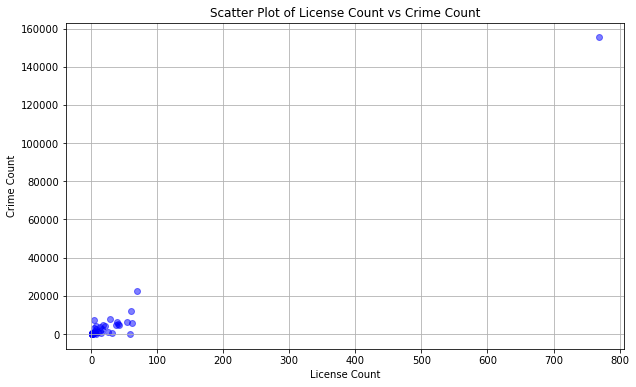

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['license_count'], merged_df['crime_count'], color='blue', alpha=0.5)
plt.xlabel('License Count')
plt.ylabel('Crime Count')
plt.title('Scatter Plot of License Count vs Crime Count')
plt.grid(True)
plt.show()

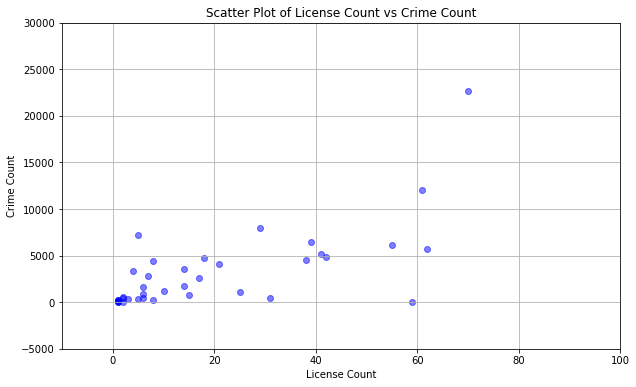

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['license_count'], merged_df['crime_count'], color='blue', alpha=0.5)
plt.xlabel('License Count')
plt.ylabel('Crime Count')
plt.title('Scatter Plot of License Count vs Crime Count')
plt.xlim(-10, 100)
plt.ylim(-5000, 30000)
plt.grid(True)
plt.show()

just try, haven't decide how to deal with nan values
and need to check assumptions



In [30]:
# from scipy.stats import linregress

# # Remove rows with NaN values for regression
# cleaned_df = merged_df.dropna()

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = linregress(cleaned_df['license_count'], cleaned_df['crime_count'])

# # Calculate regression line
# regression_line = slope * cleaned_df['license_count'] + intercept

# # Draw scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(merged_df['license_count'], merged_df['crime_count'], color='blue', alpha=0.5, label='Data points')
# plt.plot(cleaned_df['license_count'], regression_line, color='red', label=f'Linear regression line\ny={slope:.2f}x+{intercept:.2f}')

# # Set axis limits
# plt.xlim(-10, 100)
# plt.ylim(-5000, 30000)

# # Add labels and title
# plt.xlabel('License Count')
# plt.ylabel('Crime Count')
# plt.title('Scatter Plot of License Count vs Crime Count with Linear Regression Line')
# plt.legend()
# plt.grid(True)

# # Display the scatter plot with regression line
# plt.show()

## OLS

In [31]:
# Calculate the count of licenses per city
license_counts = sub_alcohol.groupby('Prem City').size().reset_index(name='license_count')
license_counts.rename(columns={'Prem City': 'city'}, inplace=True)

In [32]:
# Calculate the count of violent crimes per city
crime_counts = sub_crime.groupby('city').size().reset_index(name='crime_count')

In [33]:
# Merge the datasets on city
merged_data = pd.merge(license_counts, crime_counts, on='city')
merged_data.head()

,city,license_count,crime_count
0,ALPINE,10,1226
1,BONITA,6,900
2,BONSALL,5,335
3,BORREGO SPRINGS,8,190
4,CAMPO,1,232


In [34]:
cities = [
    'CARLSBAD',
    'CHULA VISTA',
    'CORONADO',
    'DEL MAR',
    'EL CAJON',
    'ENCINITAS',
    'ESCONDIDO',
    'IMPERIAL BEACH',
#     'LA JOLLA',
    'LA MESA',
    'NATIONAL CITY',
    'OCEANSIDE',
    'POWAY',
    'SAN DIEGO',
    'SAN MARCOS',
    'SANTEE',
    'SOLANA BEACH',
    'VISTA'
]

population data: https://data.census.gov/table/DECENNIALPL2020.P1?g=160XX00US0611194,0613392,0616378,0618506,0621712,0622678,0622804,0636294,0640004,0650398,0653322,0658520,0666000,0668196,0670224,0672506,0682996_8610000US92093_880XX00US9203706073&tp=true

In [35]:
pop = pd.read_csv("population.csv")
population = pop.dropna().reset_index(drop=True)
population['Total:'] = population['Total:'].str.replace(',', '').astype(int)
population.rename(columns={'Label (Grouping)': 'city', 'Total:': 'population'}, inplace=True)
population['city'] = cities

population.head()

,city,population
0,CARLSBAD,114746
1,CHULA VISTA,275487
2,CORONADO,20192
3,DEL MAR,3954
4,EL CAJON,106215


In [36]:
merged_data = pd.merge(merged_data, population, on='city')
merged_data

,city,license_count,crime_count,population
0,CARLSBAD,62,5707,114746
1,CHULA VISTA,70,22689,275487
2,CORONADO,31,423,20192
3,DEL MAR,15,723,3954
4,EL CAJON,42,4831,106215
5,ENCINITAS,38,4567,62007
6,ESCONDIDO,55,6180,151038
7,IMPERIAL BEACH,7,2800,26137
8,LA MESA,41,5204,61121
9,NATIONAL CITY,18,4769,56173


miss counfounding variable

In [37]:
import statsmodels.api as sm

# Define the dependent and independent variables
X = merged_data['license_count']/merged_data['population']
y = merged_data['crime_count']/merged_data['population']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Display the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     7.851
Date:                Thu, 30 May 2024   Prob (F-statistic):             0.0134
Time:                        18:42:58   Log-Likelihood:                 36.601
No. Observations:                  17   AIC:                            -69.20
Df Residuals:                      15   BIC:                            -67.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0593      0.010      6.167      0.0

/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [38]:
# Step 1: Extract the list of cities from merged_data
cities = merged_data['city'].unique()

# Step 2: Filter sub_crime and sub_alcohol to include only rows where the city is in the list of cities from merged_data
filtered_crime = sub_crime[sub_crime['city'].isin(cities)]
filtered_alcohol = sub_alcohol[sub_alcohol['Prem City'].isin(cities)]

# Step 3: Convert zip codes to integers
filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)

# Step 4: Extract unique zip codes and their corresponding cities from the filtered dataframes
unique_crime_zipcodes = filtered_crime[['zipcode', 'city']].drop_duplicates()
unique_alcohol_zipcodes = filtered_alcohol[['Prem Zip', 'Prem City']].drop_duplicates()

# Step 5: Rename columns to have consistent names for merging
unique_alcohol_zipcodes = unique_alcohol_zipcodes.rename(columns={'Prem Zip': 'zipcode', 'Prem City': 'city'})

# Step 6: Combine the unique zip codes and their corresponding cities, and remove duplicates
all_unique_zipcodes = pd.concat([unique_crime_zipcodes, unique_alcohol_zipcodes]).drop_duplicates()


all_unique_zipcodes

/tmp/ipykernel_811/951107424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
/tmp/ipykernel_811/951107424.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)


,zipcode,city
0,91950,NATIONAL CITY
1,92109,SAN DIEGO
2,92115,SAN DIEGO
5,92126,SAN DIEGO
6,92037,SAN DIEGO
...,...,...
301587,92102,CHULA VISTA
305473,92023,CARLSBAD
68,92011,CARLSBAD
436,92081,VISTA
